# More Classification

$$
\renewcommand{\like}{{\cal L}}
\renewcommand{\loglike}{{\ell}}
\renewcommand{\err}{{\cal E}}
\renewcommand{\dat}{{\cal D}}
\renewcommand{\hyp}{{\cal H}}
\renewcommand{\Ex}[2]{E_{#1}[#2]}
\renewcommand{\x}{{\mathbf x}}
\renewcommand{\v}[1]{{\mathbf #1}}
$$

In [2]:
%matplotlib inline
import numpy as np
import scipy as sp
import matplotlib as mpl
import matplotlib.cm as cm
import matplotlib.pyplot as plt
import pandas as pd
pd.set_option('display.width', 500)
pd.set_option('display.max_columns', 100)
pd.set_option('display.notebook_repr_html', True)
import seaborn as sns
sns.set_style("whitegrid")
sns.set_context("poster")
from PIL import Image

//anaconda/lib/python2.7/site-packages/IPython/html.py:14: ShimWarning: The `IPython.html` package has been deprecated. You should import from `notebook` instead. `IPython.html.widgets` has moved to `ipywidgets`.
  "`IPython.html.widgets` has moved to `ipywidgets`.", ShimWarning)


In [3]:
c0=sns.color_palette()[0]
c1=sns.color_palette()[1]
c2=sns.color_palette()[2]

In [4]:
from matplotlib.colors import ListedColormap
cmap_light = ListedColormap(['#FFAAAA', '#AAFFAA', '#AAAAFF'])
cmap_bold = ListedColormap(['#FF0000', '#00FF00', '#0000FF'])
cm = plt.cm.RdBu
cm_bright = ListedColormap(['#FF0000', '#0000FF'])

def points_plot(ax, Xtr, Xte, ytr, yte, clf, mesh=True, colorscale=cmap_light, cdiscrete=cmap_bold, alpha=0.1, psize=10, zfunc=False, predicted=False):
    h = .02
    X=np.concatenate((Xtr, Xte))
    x_min, x_max = X[:, 0].min() - .5, X[:, 0].max() + .5
    y_min, y_max = X[:, 1].min() - .5, X[:, 1].max() + .5
    xx, yy = np.meshgrid(np.linspace(x_min, x_max, 100),
                         np.linspace(y_min, y_max, 100))

    #plt.figure(figsize=(10,6))
    if zfunc:
        p0 = clf.predict_proba(np.c_[xx.ravel(), yy.ravel()])[:, 0]
        p1 = clf.predict_proba(np.c_[xx.ravel(), yy.ravel()])[:, 1]
        Z=zfunc(p0, p1)
    else:
        Z = clf.predict(np.c_[xx.ravel(), yy.ravel()])
    ZZ = Z.reshape(xx.shape)
    if mesh:
        plt.pcolormesh(xx, yy, ZZ, cmap=cmap_light, alpha=alpha, axes=ax)
    if predicted:
        showtr = clf.predict(Xtr)
        showte = clf.predict(Xte)
    else:
        showtr = ytr
        showte = yte
    ax.scatter(Xtr[:, 0], Xtr[:, 1], c=showtr-1, cmap=cmap_bold, s=psize, alpha=alpha,edgecolor="k")
    # and testing points
    ax.scatter(Xte[:, 0], Xte[:, 1], c=showte-1, cmap=cmap_bold, alpha=alpha, marker="s", s=psize+10)
    ax.set_xlim(xx.min(), xx.max())
    ax.set_ylim(yy.min(), yy.max())
    return ax,xx,yy

In [5]:
def points_plot_prob(ax, Xtr, Xte, ytr, yte, clf, colorscale=cmap_light, cdiscrete=cmap_bold, ccolor=cm, psize=10, alpha=0.1):
    ax,xx,yy = points_plot(ax, Xtr, Xte, ytr, yte, clf, mesh=False, colorscale=colorscale, cdiscrete=cdiscrete, psize=psize, alpha=alpha, predicted=True) 
    Z = clf.predict_proba(np.c_[xx.ravel(), yy.ravel()])[:, 1]
    Z = Z.reshape(xx.shape)
    plt.contourf(xx, yy, Z, cmap=ccolor, alpha=.2, axes=ax)
    cs2 = plt.contour(xx, yy, Z, cmap=ccolor, alpha=.6, axes=ax)
    plt.clabel(cs2, fmt = '%2.1f', colors = 'k', fontsize=14, axes=ax)
    return ax 

## The ATM Camera example

Imagine that you are tasked whith making a smart ATM camera which can distinguish between dollar notes and checks. You want to make sure that dollars are not classified as checks, and that checks are not classified as dollars.

You are given a set of 87 images of checks and dollars, each of which have been scaled to 322 X 137 pixels, and where each pixel has 3 color channels.

`imag.pix.npy` is 80M. Download it from https://dl.dropboxusercontent.com/u/75194/imag.pix.npy and copy it to the data subfolder.

In [8]:
data=np.load("data/imag.pix.npy")
y=np.load("data/imag.lbl.npy")
STANDARD_SIZE = (322, 137)#standardized pixels in image.
data.shape, y.shape

((87, 132342), (87,))

In [9]:
def get_image(mat):
    size = STANDARD_SIZE[0]*STANDARD_SIZE[1]*3
    r,g,b = mat[0:size:3], mat[1:size:3],mat[2:size:3]
    rgbArray = np.zeros((STANDARD_SIZE[1],STANDARD_SIZE[0], 3), 'uint8')#3 channels
    rgbArray[..., 0] = r.reshape((STANDARD_SIZE[1], STANDARD_SIZE[0]))
    rgbArray[..., 1] = b.reshape((STANDARD_SIZE[1], STANDARD_SIZE[0]))
    rgbArray[..., 2] = g.reshape((STANDARD_SIZE[1], STANDARD_SIZE[0]))
    return rgbArray

def display_image(mat):
    with sns.axes_style("white"):
        plt.imshow(get_image(mat))
        plt.xticks([])
        plt.yticks([])

We display some of the images that we have:

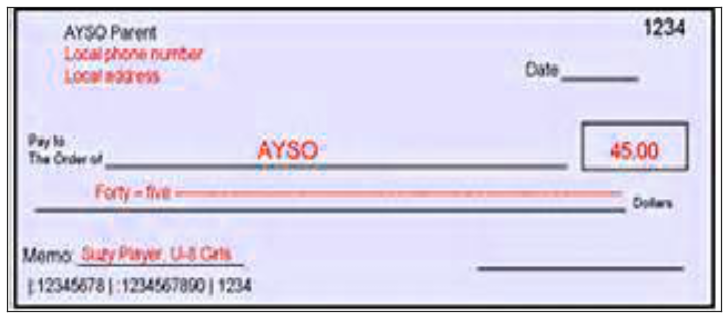

In [10]:
display_image(data[5])

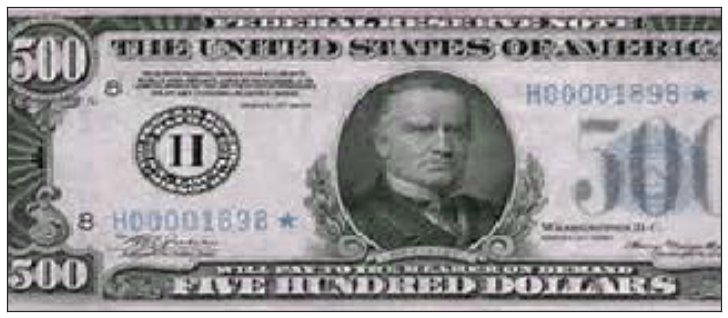

In [11]:
display_image(data[50])

What do you think are some of the aspects of these images that will help us distinguish checks from dollars?

### The curse of dimensionality: Feature engineering

The first thing that you notice is that you have many many features: to be precise, $322 x 137 x 3 = 136452$ of them. This is a lot of features! Having too many features can lead to overfitting.

You have seem this before! Remember when we did the polynomial regression? When we tried to find fits in $\hyp_1$, there were two features, the constant, and $x$. In $\hyp_2$, there are 3: the constant, $x$, and $x^2$. When we get to $\hyp_{20}$, there are 21: the constant, and 20 powers of x. And then we saw how regularization tried to eliminate some of these powers by sending their co-efficients in the polynomial very close to 0, thus reducing the number of features we had.

Another way to look at this problem is the following: we have 85 data points, but 136452 features; that is, way more features than data points. Thus there is a high chance that a few attributes will correlate with $y$ purely coincidentally!
[^Having lots of images, or "big-data" helps in combatting overfitting!]

We need to do something similar to what happened in the regularized regression here! We will engage in some *a-priori* feature selection that will reduce the dimensionality of the problem. The idea we'll use here is something called **Principal Components Analysis**, or PCA.

PCA is an unsupervized learning technique. The basic idea behind PCA is to rotate the co-ordinate axes of the feature space. We first find the direction in which the data varies the most. We set up one co-ordinate axes along this direction, which is called the first principal component. We then look for a perpendicular direction in which the data varies the second most. This is the second principal component. The diagram illustrates this process. There are as many principal components as the feature dimension: all we have done is a rotation.

![pcanim](images/pcanim.gif)

(diagram taken from http://stats.stackexchange.com/questions/2691/making-sense-of-principal-component-analysis-eigenvectors-eigenvalues which also has nice discussions)

How does this then achieve feature selection? We decide on a threshold of variation; once the variation in a particular direction falls below a certain number, we get rid of all the co-ordinate axes after that principal component. For example, if the variation falls below 10% after the third axes, and we decide that 10% is an acceptable cutoff, we remove all domensions from the fourth dimension onwards. In other words, we took our higher dimensional problem and projected it onto a 3 dimensional **subspace**.

We do not have to do this dimensionality reduction unsupervized. Indeed, you will see some supervized dimensionality reduction in the homework.

These two ideas illustrate one of the most important reasons that learning is even feasible: we believe that **most datasets, in either their unsupervized form $\{\v{x\}}$, or their supervized form $\{y, \v{x}\}$, live on a lower dimensional subspace**. If we can find this subspace, we can then hope to find a methodd which rerpectively separates or fits the data.

Here we'll continue to focus on PCA. We'll reduce our dimensionality from 136452 to 60. We choose 60 as a large apriori number: we dont know if the variation in the data will have gone below a reasonable threshold by then. Notice that we use `fit_transform` in the `sklearn` API which takes the original 87 rows x 136452 columns dimensional data `data` and transforms it to a 87 x 90 data matrix `X`.

In [12]:
from sklearn.decomposition import PCA
pca = PCA(n_components=60)
X = pca.fit_transform(data)

In [13]:
print(pca.explained_variance_ratio_.sum())

0.942879528617


The explained variance ratio `pca.explained_variance_ratio_` tells us how much of the variation in the features is explained by these 60 features. When we sum it up over the features, we see that 94% is explained: good enough to go down to a 60 dimensional space from a 136452 dimensional one!

We can see the individual variances as we increase the dimensionality:

In [14]:
pca.explained_variance_ratio_*100

array([ 35.92596698,   6.29318801,   4.10778347,   3.11950952,
         2.81695972,   2.28831619,   2.10127949,   1.87404975,
         1.73264637,   1.53023773,   1.42159671,   1.318394  ,
         1.24701539,   1.16381841,   1.09958324,   1.06073157,
         1.00743046,   0.98023869,   0.96055948,   0.91535856,
         0.90185612,   0.85213309,   0.8367458 ,   0.79692356,
         0.75489846,   0.72505562,   0.70821781,   0.6796765 ,
         0.66092535,   0.64772084,   0.62739233,   0.59477344,
         0.58303101,   0.57450926,   0.57278186,   0.55261734,
         0.53858717,   0.53343191,   0.51665709,   0.49343182,
         0.48594565,   0.47762236,   0.47284194,   0.45620017,
         0.44417076,   0.44004494,   0.4346039 ,   0.42800383,
         0.42195733,   0.4100348 ,   0.40554006,   0.39424777,
         0.38943727,   0.38311261,   0.37925514,   0.36341299,
         0.36062508,   0.3497255 ,   0.34022686,   0.33491379])

The first dimension accounts for 35% of the variation, the second 6%, and it goes steadily down from there.

Let us create a dataframe with these 60 features labelled pc1,pc2...,pc60 and the labels of the sample:

In [15]:
df = pd.DataFrame({"y":y, "label":np.where(y==1, "check", "dollar")})
for i in range(pca.explained_variance_ratio_.shape[0]):
    df["pc%i" % (i+1)] = X[:,i]
df.head()

,label,y,pc1,pc2,pc3,pc4,pc5,pc6,pc7,pc8,pc9,pc10,pc11,pc12,pc13,pc14,pc15,pc16,pc17,pc18,pc19,pc20,pc21,pc22,pc23,pc24,pc25,pc26,pc27,pc28,pc29,pc30,pc31,pc32,pc33,pc34,pc35,pc36,pc37,pc38,pc39,pc40,pc41,pc42,pc43,pc44,pc45,pc46,pc47,pc48,pc49,pc50,pc51,pc52,pc53,pc54,pc55,pc56,pc57,pc58,pc59,pc60
0,check,1,-22536.362571,2428.343967,2133.777242,-328.322450,1065.239885,-79.779510,425.028862,-622.482412,2490.207981,858.586365,-1072.565326,277.135956,-1117.008245,712.921050,-787.542306,414.930152,-195.835369,472.439595,-429.687952,609.645649,-588.997035,-266.805059,987.770869,-953.085804,1037.093164,-568.689960,-42.940841,-112.654017,520.389800,545.386992,-643.325633,-77.820997,-733.674370,1263.879103,586.756998,119.593373,-508.370089,-294.174840,-252.519347,-51.538313,-457.830940,758.886057,515.916103,440.076107,-463.097417,-225.847169,-72.615736,-280.709429,-588.030969,-448.784198,539.070474,173.421252,379.865134,160.692953,157.257050,450.314126,-227.221397,-112.364944,-186.038429,-68.330989
1,check,1,-22226.658684,709.255778,288.826225,-1300.635376,792.084752,-217.442930,-1076.777444,2115.106737,875.462523,1124.846524,-343.234147,-43.368372,547.937212,357.548885,-1761.499582,-372.120164,813.766003,293.993188,-941.050102,-154.191592,-1122.863363,507.700410,815.875978,-717.999469,289.149370,115.870070,816.665466,1144.817760,359.342436,120.101878,-851.744626,-582.296067,316.394094,176.118549,673.219112,657.451216,94.661336,192.333834,-142.834165,376.042041,120.771967,20.335283,697.047946,-22.197777,-299.883777,22.574739,-26.094463,-290.112096,1147.013054,318.365764,426.590209,-81.492381,218.911740,-293.833368,-574.800385,461.005213,-133.873301,86.549876,-68.253606,194.165434
2,check,1,-17364.260784,4252.027148,-793.802239,-1362.054543,374.230509,-3142.098137,-2514.239438,-1443.845989,121.012593,419.751003,-2083.156756,1717.655662,-723.242074,-1240.426110,-310.766668,-1059.408079,1385.595045,-799.959051,-2598.756819,880.676052,3384.434883,-389.628097,3414.296511,-1340.080791,-4755.217740,-1036.255043,2198.383527,-687.340263,-1379.299146,-2148.507251,-644.565929,-1683.784601,1774.957382,-3132.874465,861.445428,-2247.593057,3105.529724,-3040.391807,843.107937,-277.652726,1718.531906,-3134.639051,3721.305222,-1470.315986,-997.252433,665.795034,-629.128117,1304.004522,-113.079572,-2860.852264,2535.136052,-1801.134606,1147.956100,1897.679487,1262.972669,2524.590385,621.040293,-422.350399,-1367.147366,-822.139175
3,check,1,-22847.256199,900.591903,-577.203148,-180.315540,733.144739,107.929873,-1441.787045,1069.822194,-844.816567,1390.008267,1470.750252,-723.940456,-578.786597,-259.303433,932.522873,170.963935,-301.561034,871.589461,-180.217083,-1238.130123,557.669686,-174.747087,332.949651,370.770361,-934.637134,-180.894557,1318.174882,92.860081,273.711601,-464.485412,-167.088608,70.342765,101.594998,834.492608,195.240356,-635.616322,-394.941809,-336.312866,130.697946,352.956334,1431.120380,-790.615542,-977.419373,-580.005826,-414.524329,-520.226448,-706.248906,327.599586,-888.099678,-1645.789093,-91.398011,0.090413,66.658666,353.418805,82.527303,-737.466496,-662.261573,-535.062574,537.059324,-528.666270
4,check,1,-15868.672595,-3259.491423,-506.800796,-919.635265,-2166.553649,981.628130,1669.697325,391.328228,-1735.708244,-163.565703,-1626.848455,-556.071285,-863.023076,1721.533650,944.390131,-1133.831269,2139.645031,766.969676,-1093.378106,-602.035479,-28.726067,83.689740,505.980050,-1106.373987,332.008248,1227.814307,-708.139610,-713.030110,142.707832,-912.989078,1012.271645,3623.483860,2107.208639,-3363.795948,966.429469,2141.451996,-1849.211068,-2139.553978,2546.960143,472.873126,135.062864,1404.581160,1283.016300,1311.779794,269.914003,-960.813470,322.601451,-850.742712,3154.415688,1425.425648,946.439659,-2233.105652,109.845355,213.800180,-3525.269984,-2516.479764,722.617389,-1742.192699,-2282.672192,1720.499388


Lets see what these principal components look like:

In [16]:
def normit(a):
    a=(a - a.min())/(a.max() -a.min())
    a=a*256
    return np.round(a)
def getNC(pc, j):
    size=322*137*3
    r=pc.components_[j][0:size:3]
    g=pc.components_[j][1:size:3]
    b=pc.components_[j][2:size:3]
    r=normit(r)
    g=normit(g)
    b=normit(b)
    return r,g,b
def display_component(pc, j):
    r,g,b = getNC(pc,j)
    rgbArray = np.zeros((137,322,3), 'uint8')
    rgbArray[..., 0] = r.reshape(137,322)
    rgbArray[..., 1] = g.reshape(137,322)
    rgbArray[..., 2] = b.reshape(137,322)
    plt.imshow(rgbArray)
    plt.xticks([])
    plt.yticks([])

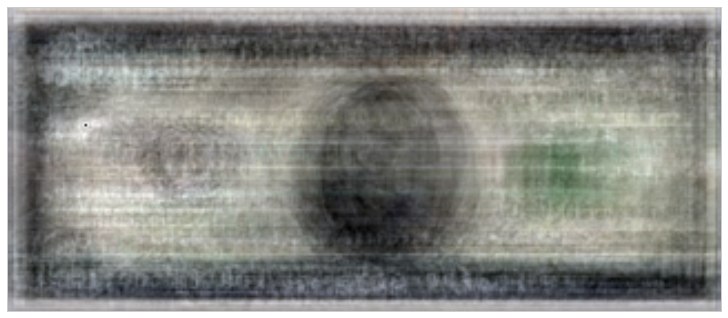

In [17]:
display_component(pca,0)

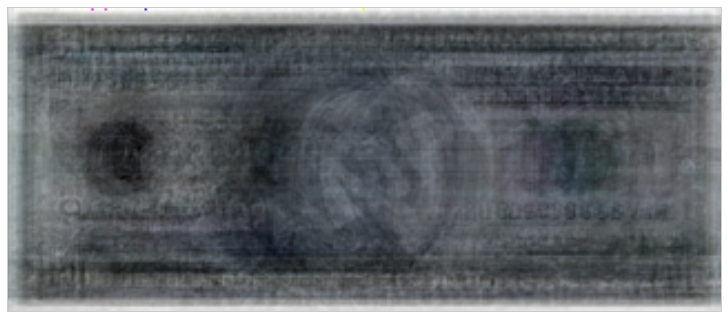

In [18]:
display_component(pca,1)

We take the first two principal components and immediately notice in the diagram below that they are enough to separate out the checks and the dollars. Indeed the first component itself seems to be mostly enough. We can look at the image of the first component and speculate that the medallion in the middle of the dollars probably contributes to this.

//anaconda/lib/python2.7/site-packages/matplotlib/collections.py:590: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  if self._edgecolors == str('face'):


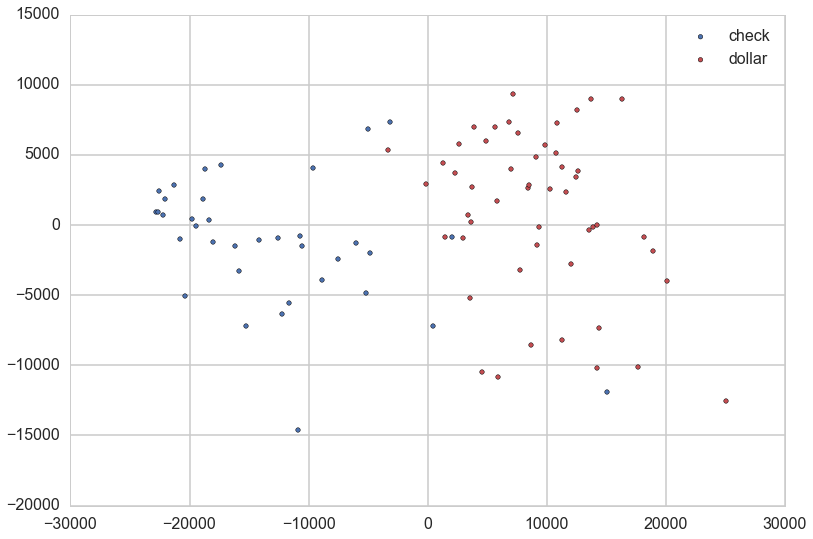

In [19]:
colors = [c0, c2]
for label, color in zip(df['label'].unique(), colors):
    mask = df['label']==label
    plt.scatter(df[mask]['pc1'], df[mask]['pc2'], c=color, label=label)
plt.legend()

You might be a bit confused: we needed to use 60 components to explain 94% of the variation in the features, but only 1 or 2 components to separate checks from dollars? This is because PCA is unsupervised: the only variation we are explaining is the variation in the 136452 dimensional feature space. We are not explaining the variation in the $y$ or the label, and it might turn out, as it does in this case, that with the additional information in $y$, the dimensionality needed for classification is much lower.

We could thus choose just the first few principal components to make our classifier. For the purposes of this lab, since two components can be easily visualized (even though adding some fore features may leads to better separability), we'll go with learning a 2-dimensional classifier in the `pc1` and `pc2` dimensions! 

### Setting up some code

In [20]:
from sklearn.grid_search import GridSearchCV
def cv_optimize(clf, parameters, Xtrain, ytrain, n_folds=5):
    gs = GridSearchCV(clf, param_grid=parameters, cv=n_folds)
    gs.fit(Xtrain, ytrain)
    print("BEST PARAMS", gs.best_params_)
    best = gs.best_estimator_
    return best

In [21]:
from sklearn.cross_validation import train_test_split
def do_classify(clf, parameters, indf, featurenames, targetname, target1val, standardize=False, train_size=0.8, sets=None):
    if sets:
        Xtrain, Xtest, ytrain, ytest = sets['Xtrain'], sets['Xtest'], sets['ytrain'], sets['ytest']
    else:       
        subdf=indf[featurenames]
        #X=subdf.values
        y=(indf[targetname].values==target1val)*1
        #Xtrain, Xtest, ytrain, ytest = train_test_split(X, y, train_size=train_size)
        itrain, itest = train_test_split(range(subdf.shape[0]), train_size=train_size)
        if standardize:
            dftrain=(subdf.iloc[itrain] - subdf.iloc[itrain].mean())/subdf.iloc[itrain].std()
            dftest=(subdf.iloc[itest] - subdf.iloc[itest].mean())/subdf.iloc[itest].std()
        else:
            dftrain=subdf.iloc[itrain]
            dftest=subdf.iloc[itest]
        Xtrain, Xtest, ytrain, ytest = dftrain.values, dftest.values, y[itrain], y[itest]
    clf = cv_optimize(clf, parameters, Xtrain, ytrain)
    clf=clf.fit(Xtrain, ytrain)
    training_accuracy = clf.score(Xtrain, ytrain)
    test_accuracy = clf.score(Xtest, ytest)
    print("Accuracy on training data: %0.2f" % (training_accuracy))
    print("Accuracy on test data:     %0.2f" % (test_accuracy))
    return clf, Xtrain, ytrain, Xtest, ytest

### Cross-validation

> YOUR TURN NOW
Lets carry out a cross-validation.  We plot the results in the diagram below. The results are fairly stable and correspond to our intuition that the first principal component basically separates the data.

In [24]:
#bestcv, Xtrain, ytrain, Xtest, ytest = ...
#your code here
from sklearn.neighbors import KNeighborsClassifier
bestcv, Xtrain, ytrain, Xtest, ytest = do_classify(KNeighborsClassifier(), {"n_neighbors": list(range(1,40,2))}, df, ['pc1','pc2'], 'label', 'check' )

('BEST PARAMS', {'n_neighbors': 5})
Accuracy on training data: 0.96
Accuracy on test data:     0.94


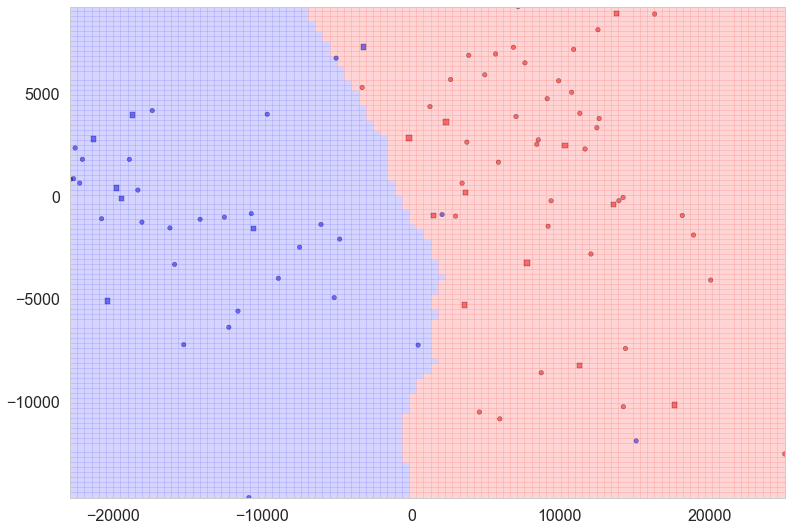

In [25]:
plt.figure()
ax=plt.gca()
points_plot(ax, Xtrain, Xtest, ytrain, ytest, bestcv, alpha=0.5, psize=20);

We can plot the probability contours as well: the probability is easily obtained by just counting the fraction of neighbors that are blue or red.

//anaconda/lib/python2.7/site-packages/matplotlib/collections.py:650: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  if self._edgecolors_original != str('face'):
//anaconda/lib/python2.7/site-packages/matplotlib/text.py:52: UnicodeWarning: Unicode equal comparison failed to convert both arguments to Unicode - interpreting them as being unequal
  if rotation in ('horizontal', None):
//anaconda/lib/python2.7/site-packages/matplotlib/text.py:54: UnicodeWarning: Unicode equal comparison failed to convert both arguments to Unicode - interpreting them as being unequal
  elif rotation == 'vertical':


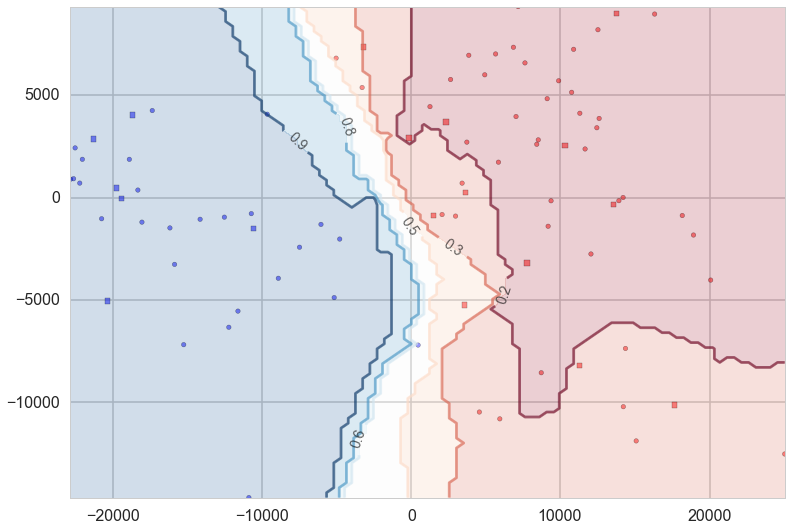

In [26]:
plt.figure()
ax=plt.gca()
points_plot_prob(ax, Xtrain, Xtest, ytrain, ytest, bestcv, alpha=0.5, psize=20);

#### Evaluation

In [27]:
from sklearn.metrics import confusion_matrix, classification_report
confusion_matrix(ytest, bestcv.predict(Xtest), )

array([[11,  0],
       [ 1,  6]])

## The confusion matrix: comparing classifiers

We have written two classifiers. A classifier will get some samples right, and some wrong. Generally we see which ones it gets right and which ones it gets wrong on the test set. There,

- the samples that are +ive and the classifier predicts as +ive are called True Positives (TP)
- the samples that are -ive and the classifier predicts (wrongly) as +ive are called False Positives (FP)
- the samples that are -ive and the classifier predicts as -ive are called True Negatives (TN)
- the samples that are +ive and the classifier predicts as -ive are called False Negatives (FN)

A classifier produces a confusion matrix from these which lookslike this:

![hwimages](./images/confusionmatrix.png)


IMPORTANT NOTE: In sklearn, to obtain the confusion matrix in the form above, always have the observed `y` first, i.e.: use as `confusion_matrix(y_true, y_pred)`

Given these definitions, we typically calculate a few metrics for our classifier. First, the **True Positive Rate**:

$$TPR = Recall = \frac{TP}{OP} = \frac{TP}{TP+FN},$$

also called the Hit Rate: the fraction of observed positives (1s) the classifier gets right, or how many true positives were recalled. Maximizing the recall towards 1 means keeping down the false negative rate. In a classifier try to find cancer patients, this is the number we want to maximize.

The **False Positive Rate** is defined as

$$FPR = \frac{FP}{ON} = \frac{FP}{FP+TN},$$

also called the False Alarm Rate, the fraction of observed negatives (0s) the classifier gets wrong. In general, you want this number to be low. Instead, you might want to maximize the
**Precision**,which tells you how many of the predicted positive(1) hits were truly positive

$$Precision = \frac{TP}{PP} = \frac{TP}{TP+FP}.$$

Finally the **F1** score gives us the Harmonic Score of Precision and Recall. Many analysts will try and find a classifier that maximizes this score, since it tries to minimize both false positives and false negatives simultaneously, and is thus a bit more precise in what it is trying to do than the accuracy.

$$F1 =  \frac{2*Recall*Precision}{Recall + Precision}$$

However, in a case like that of a cancer classifier, we will wish to minimize false nagatives at the expense of false positives: it is ok to send perfectly healthy patients for cancer folloup if that is the price we must pay for not missing any sick ones.

`scikit-learn` helpfully gives us a classification report with all these numbers

#### The cancer doctor

Do you really want to be setting a threshold of 0.5 probability to predict if a patient has cancer or not? The false negative problem: ie the chance you predict someone dosent have cancer who has cancer is much higher for such a threshold. You could kill someone by telling them not to get a biopsy. Why not play it safe and assume a much lower threshold: for eg, if the probability of 1(cancer) is greater than 0.05, we'll call it a 1.

In [30]:
df=pd.read_csv("data/01_heights_weights_genders.csv")
df.head()

,Gender,Height,Weight
0,Male,73.847017,241.893563
1,Male,68.781904,162.310473
2,Male,74.110105,212.740856
3,Male,71.730978,220.042470
4,Male,69.881796,206.349801


In [31]:
from sklearn.linear_model import LogisticRegression
clf_l, Xtrain_l, ytrain_l, Xtest_l, ytest_l  = do_classify(LogisticRegression(), {"C": [0.01, 0.1, 1, 10, 100]}, df, ['Height', 'Weight'], 'Gender','Male')

('BEST PARAMS', {'C': 0.01})
Accuracy on training data: 0.92
Accuracy on test data:     0.93


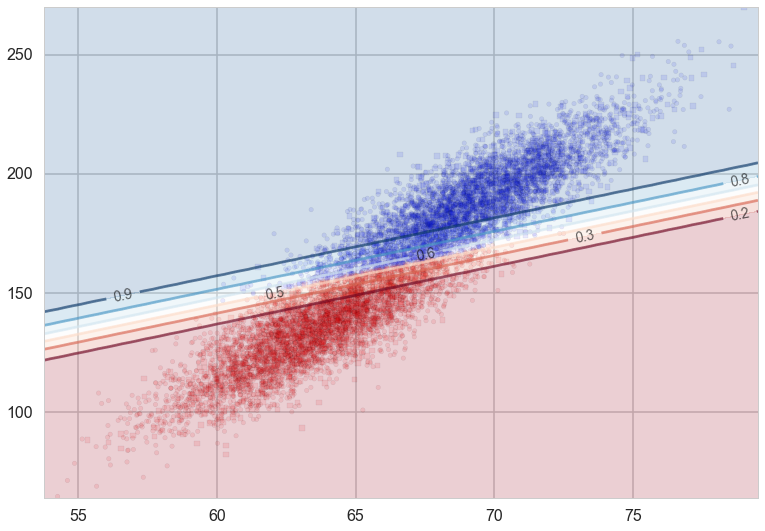

In [32]:
plt.figure()
ax=plt.gca()
points_plot_prob(ax, Xtrain_l, Xtest_l, ytrain_l, ytest_l, clf_l, psize=20, alpha=0.1);

In [36]:
confusion_matrix(ytest_l, clf_l.predict(Xtest_l))

array([[890,  63],
       [ 79, 968]])

In [37]:
def t_repredict(est,t, xtest):
    probs=est.predict_proba(xtest)
    p0 = probs[:,0]
    p1 = probs[:,1]
    ypred = (p1 > t)*1
    return ypred

In [38]:
confusion_matrix(ytest_l, t_repredict(clf_l, 0.1, Xtest_l))

array([[ 698,  255],
       [  22, 1025]])

## ROC Curve

The images in this section are from Provost, Foster; Fawcett, Tom (2013-07-27). Data Science for Business: What you need to know about data mining and data-analytic thinking  O'Reilly Media. Great book!

We can check on the thresholds we talked about in the previous section and compare our classifiers to each other and the baseline models using the ROC curves you learned about in class. 

Remember that ROC curves are actually a set of classifiers, in which we move the threshold for classifying a sample as positive from 1 to 0. Each point on a ROC curve is a separate classifier obtained by considering a different threshold. (In the standard scenario, where we used the  classifier accuracy, this threshold is implicitly set at 0.5, and we have only one classifier).

![m:roc curve](images/roc-curve.png)

The way ROC curves are calulated is this. We start with a large threshold, something like 0.99 or so. This means that only samples with a probability of being positive higher than that threshold are classified as positive. That is the really really really positive ones! The idea then is to decrease this threshold, such that more and more samples get classified as positive.

![howto roc](images/howtoroc.png)

The practical way to do this is to order the samples by probability of being positive, or in the case of the SVM, by the `decision_function` or distance from the separating hyperplane. Then consider the sample with the highest score or highest probability of being positive. At first, only this sample is positive. Then, we take the sample with the next highest score, and call it positive. As we go down the list, we go down a threshold in score or probability. 

Now, for each such situation: only 1 positive, now 2 positive,....you can imagine a different classifier with a different confusion matrix. It will have its own false positives, tre positives, etc. Its actually the same original classifier, but with a different threshold each time.

As we keep going down the list, decreasing the threshold, more and more samples become positive, and at first, the true positives rise faster than the false positives. Once past a certain point, false positives increase faster than true positives. Now, if you want a balanced classifier, you look at this turn-around point...the northwest corner, so to speak. But if you want a classifier which penalizes false positives and false negatives differently, the point you want is different.

Here is the confusion matrix again:

![hwimages](./images/confusionmatrix.png)


To make a ROC curve you plot the True Positive Rate, 

$$TPR=\frac{TP}{OP}$$

against the False Positive Rate,

$$FPR=\frac{FP}{ON}$$

as you go through this process of going down the list of samples. ROC curves are useful because they calculate one classifier per threshold and show you where you are in TPR/FPR space without making any assumptions about the utility matrix or which threshold is appropriate.

Notice that the ROC curve has a very interesting property: if you look at the confusion matrix above, TPR is only calculated from the observed "1" row while FPR is calculated from the observed '0' row. This means that the ROC curve is independent of the class balance/imbalance on the test set, and thus works for all ratios of positive to negative samples. The balance picks a point on the curve, as you can read below.

A rote reading of the ROC curve (go to the "northwest" corner) is a bad idea: you must fold in the curve with any assumptions you are making about costs. More on this in the next lab. Still, on the whole, a curve with a greater AUC (area under curve), or further away from the line of randomness, will give us a rough idea of what might be a better classifier.



In [64]:
def make_roc(name, clf, ytest, xtest, ax=None, labe=5, proba=True, skip=0):
    initial=False
    if not ax:
        ax=plt.gca()
        initial=True
    if proba:
        fpr, tpr, thresholds=roc_curve(ytest, clf.predict_proba(xtest)[:,1])
    else:
        fpr, tpr, thresholds=roc_curve(ytest, clf.decision_function(xtest))
    roc_auc = auc(fpr, tpr)
    if skip:
        l=fpr.shape[0]
        ax.plot(fpr[0:l:skip], tpr[0:l:skip], 'o-', alpha=0.4, label='ROC curve for %s (area = %0.2f)' % (name, roc_auc))
    else:
        ax.plot(fpr, tpr, '.-', alpha=0.2, label='ROC curve for %s (area = %0.2f)' % (name, roc_auc))
    label_kwargs = {}
    label_kwargs['bbox'] = dict(
        boxstyle='round,pad=0.1', alpha=0.1,
    )
    for k in range(0, fpr.shape[0],labe):
        #from https://gist.github.com/podshumok/c1d1c9394335d86255b8
        threshold = str(np.round(thresholds[k], 2))
        ax.annotate(threshold, (fpr[k], tpr[k]), **label_kwargs)
    if initial:
        ax.plot([0, 1], [0, 1], 'k--')
        ax.set_xlim([0.0, 1.0])
        ax.set_ylim([0.0, 1.05])
        ax.set_xlabel('False Positive Rate')
        ax.set_ylabel('True Positive Rate')
        ax.set_title('ROC')
    ax.legend(loc="lower right")
    return ax

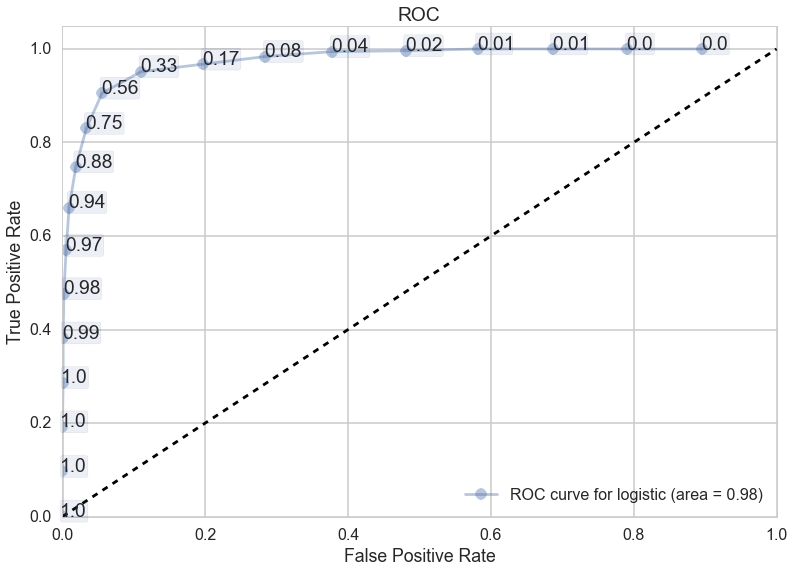

In [65]:
from sklearn.metrics import roc_curve, auc
ax=make_roc("logistic", clf_l, ytest_l, Xtest_l, labe=100, skip=100)

In [66]:
sets = dict(Xtrain=Xtrain_l, ytrain=ytrain_l, Xtest=Xtest_l, ytest = ytest_l)
clf_knn, Xtrain_l, ytrain_l, Xtest_l, ytest_l  = do_classify(KNeighborsClassifier(), {"n_neighbors": list(range(1,20,1))}, df, ['Height','Weight'], 'Gender', 'Male' , standardize=True, sets=sets)

('BEST PARAMS', {'n_neighbors': 19})
Accuracy on training data: 0.92
Accuracy on test data:     0.92


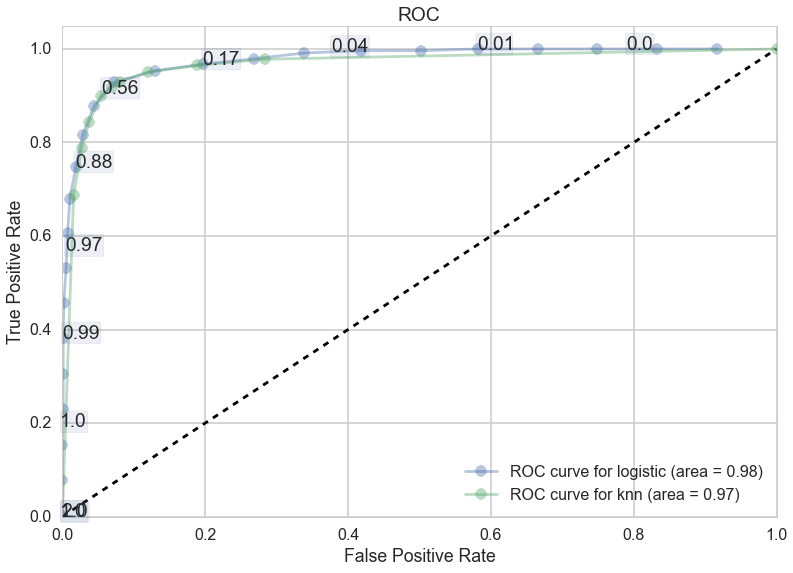

In [74]:
from sklearn.metrics import roc_curve, auc
ax=make_roc("logistic", clf_l, ytest_l, Xtest_l, labe=200, skip=80)
make_roc("knn", clf_knn, ytest_l, Xtest_l, ax=ax, labe=200, skip=2)